## XGBoost

Random Forests take the majority or average result of independent estimators (decision trees).

Boosting is another method of combining multiple decision trees. With boosting, we work sequentially with multiple models. After each model has been built, we look at the errors this model is making and use this knowledge to train the next model, attempting to reduce these errors.

We sequentially train models and each model attempts to correct the mistakes of its predecessor. Each model will produce predictions and our final prediction is based on the average of majority result of all the estimators.

XGBoost is a type of boosting where each model is a decision tree.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm.auto import tqdm

In [2]:
df_collision = pd.read_csv("data/collisions_final.csv")
df_collision.head(2)

,police_force,number_of_vehicles,day_of_week,time,first_road_class,road_type,speed_limit,light_conditions,weather_conditions,road_surface_conditions,is_severe,month,day_of_year,is_trunk,is_near_pedestrian_crossing,is_urban,has_special_conditions_at_site,is_carriageway_hazard,is_near_junction
0,metropolitan_police,1,sunday,01:00,c,one_way_street,20,darkness___lights_lit,other_adverse_weather_condition,wet_or_damp,0,january,1,0,1,1,0,0,1
1,metropolitan_police,3,sunday,02:00,unclassified,single_carriageway,30,darkness___lights_lit,fine_no_high_winds,dry,0,january,1,0,1,1,0,0,1


## Prepare data


In [53]:
df_full_train, df_test = train_test_split(df_collision, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["is_severe"].values
y_val = df_val["is_severe"].values
y_test = df_test["is_severe"].values

del df_train["is_severe"]
del df_val["is_severe"]
del df_test["is_severe"]

In [4]:
x_train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(x_train_dicts)
X_train = dv.transform(x_train_dicts)
# additional transforming for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)
# additional transforming for XGBoost
dval = xgb.DMatrix(X_val, label=y_val, feature_names = list(dv.get_feature_names_out()))

## Base model

We will train an initial XGBoost model using the defaults and then later tune some of these parameters to try and improve the model.

### Background on XGBoost parameters

XGBoost has three sets of parameters

1. general parameters: the key one to set here is the type of booster.
   
- `booster`: type of booster. We will use the default `gbtree` (a booster using tree based models)


2.. booster parameters: these are specific to the booster chosen. For our tree booster, we will look at

- `eta`: this is the learning rate i.e. how fast our model learns, range: [0,1]
  
- `max_depth`: similar to RandomForest, this is the max depth of the tree. Increasing the depth makes the model more complex with the added danger of it overfitting, range: [0,∞]


  
- `min_child_weight`: similar to `min_samples_leaf`, range: [0,∞]

3. learning task parameters: here is when you decide on the learning scenario.

- `objective`: what type of learning are you doing. We are performing a binary classification i.e. `binary:logistic`
  
- `eval_metric`: how do you want the model to be evaluated e.g. you could evaluate with root mean squared error, roc_auc_score. We will stick with the latter, which is `auc`.

In [46]:
num_boost_round = 10 # default

xgb_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': 0.3, # default
    'max_depth': 6, # default,
    'min_child_weight': 1, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dval)

roc_auc_score_base = roc_auc_score(y_val, y_pred)
roc_auc_score_base

np.float64(0.622532338315994)

**Observations**

`roc_auc_score`: Our base random forest model has an `roc_auc_score` of around 0.623. Given that our RandomForest model's score was 0.628 after tuning, this is not a bad start.

## Model Tuning

### How many boosting iterations should we have? (num_boost_round)

Boosting works by iterating on the results of previous decision trees. The more rounds we have, the less error but we do increase our risk of overfitting.

**Note on evaluation**

When tuning other models, we calculated the `roc_auc_score` manually. We can get XGBoost's evaluation after each iteration by passing in a watchlist to `evals`. This is a list of datasets that you want to evaluate at each iteration. We want the training and validation sets to be tested.

In the lectures we printed the results to the console but I found that I could capture the results using an `evals_result` parameter. See [XGBoost docs example](https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html)

**Approach**

I follow the approach in the lectures and run 200 rounds with XGBoost outputting the results after every round in order to get a sense of how many iterations are optimal.

All the other parameters remain as default.

In [6]:
watchlist = [(dtrain, "train"), (dval, "val")]

def train_and_evaluate(xgb_p, num_boost_round=10):
    """Train and evaluate a Gradient Boost model with provided parameters
    
    Returns
    -------
    pd.DataFrame with auc_scores for training and validation datasets after every iteration
    """
    evals_results = {}
    model = xgb.train(xgb_p, dtrain, num_boost_round=num_boost_round, evals=watchlist, evals_result=evals_results)

    train_results = evals_results["train"]["auc"]
    val_results = evals_results["val"]["auc"]
    n_iter = range(0,num_boost_round)
    df_results = pd.DataFrame({"num_iter": n_iter, "train_auc": train_results, "val_auc": val_results})  
    return df_results

In [7]:
num_boost_round = 200

xgb_params = {
    'booster': 'gbtree', # default
    'verbosity': 0, # turn off logs
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': 0.3, # default
    'max_depth': 6, # default,
    'min_child_weight': 1, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

df_scores = train_and_evaluate(xgb_params, num_boost_round)
df_scores.sort_values(by="val_auc", ascending=False)

[0]	train-auc:0.60997	val-auc:0.59872
[1]	train-auc:0.61965	val-auc:0.60998
[2]	train-auc:0.62482	val-auc:0.61141
[3]	train-auc:0.63256	val-auc:0.61663
[4]	train-auc:0.63755	val-auc:0.61864
[5]	train-auc:0.64252	val-auc:0.61902
[6]	train-auc:0.64612	val-auc:0.61981
[7]	train-auc:0.65243	val-auc:0.62157
[8]	train-auc:0.65773	val-auc:0.62205
[9]	train-auc:0.66062	val-auc:0.62253
[10]	train-auc:0.66367	val-auc:0.62199
[11]	train-auc:0.66810	val-auc:0.62246
[12]	train-auc:0.67142	val-auc:0.62378
[13]	train-auc:0.67298	val-auc:0.62341
[14]	train-auc:0.67602	val-auc:0.62312
[15]	train-auc:0.67926	val-auc:0.62340
[16]	train-auc:0.68258	val-auc:0.62404
[17]	train-auc:0.68500	val-auc:0.62471
[18]	train-auc:0.68695	val-auc:0.62480
[19]	train-auc:0.68943	val-auc:0.62552
[20]	train-auc:0.69168	val-auc:0.62565
[21]	train-auc:0.69278	val-auc:0.62508
[22]	train-auc:0.69499	val-auc:0.62468
[23]	train-auc:0.69733	val-auc:0.62489
[24]	train-auc:0.69869	val-auc:0.62461
[25]	train-auc:0.70019	val-auc:0.62

,num_iter,train_auc,val_auc
20,20,0.691684,0.625653
19,19,0.689430,0.625519
21,21,0.692776,0.625081
23,23,0.697335,0.624893
18,18,0.686948,0.624800
...,...,...,...
196,196,0.846193,0.600891
197,197,0.846315,0.600720
198,198,0.846715,0.600649
199,199,0.847232,0.600598


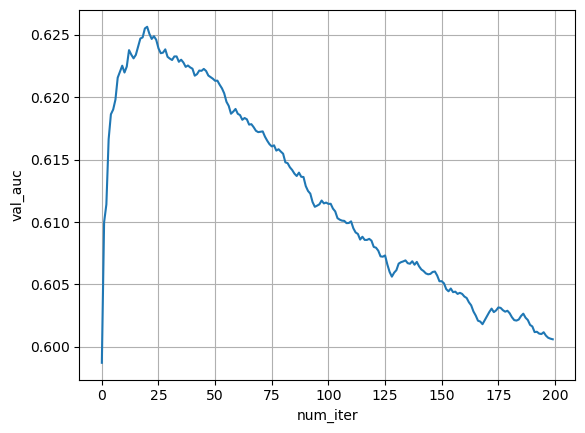

In [8]:
sns.lineplot(data=df_scores, x="num_iter", y="val_auc")
plt.grid()
plt.show()

**Conclusion**

We can see that we hit our peak performance in the validation set at 20 iterations where the validation auc score is 	0.625653. After this performance diminishes.

It's worth noting that we are using the default learning rate here, which is 0.3. 0.3 is quite a high learning rate and there is a relationship between the number of boosting rounds and the learning rate. It's possible that a lower learning rate might require more iterations but actually produce a better result. In this sense, we can't really identify the optimal number of iterations yet.

### What's the ideal learning rate?

The default learning rate (0.3) is quite high. We will look at a range.

In [9]:
num_boost_round = 200

eta_test_values = [0.01,0.05,0.08,0.1,0.2,0.3,1]

scores_eta = {}

for learning_rate in tqdm(eta_test_values):
    xgb_params = {
        'booster': 'gbtree', # default
        'verbosity': 0, # turn off logs
        'nthread': 6, # how many cores/ how much parallelization, depends on your system
    
        'eta': learning_rate, 
        'max_depth': 6, # default,
        'min_child_weight': 1, # default
    
        'objective' :'binary:logistic', 
        'seed': 1, # random number seed to make the results reproducible
        'eval_metric': 'auc'
    }

    key = f'eta={learning_rate}'
    scores_eta[key] = train_and_evaluate(xgb_params, num_boost_round)

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.60997	val-auc:0.59872
[1]	train-auc:0.61001	val-auc:0.59864
[2]	train-auc:0.61100	val-auc:0.60166
[3]	train-auc:0.61185	val-auc:0.60087
[4]	train-auc:0.61160	val-auc:0.60173
[5]	train-auc:0.61190	val-auc:0.60240
[6]	train-auc:0.61300	val-auc:0.60361
[7]	train-auc:0.61313	val-auc:0.60387
[8]	train-auc:0.61314	val-auc:0.60377
[9]	train-auc:0.61333	val-auc:0.60399
[10]	train-auc:0.61373	val-auc:0.60397
[11]	train-auc:0.61385	val-auc:0.60392
[12]	train-auc:0.61398	val-auc:0.60421
[13]	train-auc:0.61400	val-auc:0.60411
[14]	train-auc:0.61467	val-auc:0.60517
[15]	train-auc:0.61501	val-auc:0.60536
[16]	train-auc:0.61505	val-auc:0.60536
[17]	train-auc:0.61572	val-auc:0.60625
[18]	train-auc:0.61583	val-auc:0.60662
[19]	train-auc:0.61626	val-auc:0.60742
[20]	train-auc:0.61814	val-auc:0.60838
[21]	train-auc:0.61802	val-auc:0.60842
[22]	train-auc:0.61851	val-auc:0.60956
[23]	train-auc:0.61831	val-auc:0.60957
[24]	train-auc:0.61801	val-auc:0.60969
[25]	train-auc:0.61884	val-auc:0.60

[8]	train-auc:0.62318	val-auc:0.61381
[9]	train-auc:0.62350	val-auc:0.61395
[10]	train-auc:0.62554	val-auc:0.61531
[11]	train-auc:0.62614	val-auc:0.61604
[12]	train-auc:0.62768	val-auc:0.61728
[13]	train-auc:0.62823	val-auc:0.61768
[14]	train-auc:0.62919	val-auc:0.61800
[15]	train-auc:0.62921	val-auc:0.61824
[16]	train-auc:0.63012	val-auc:0.61888
[17]	train-auc:0.63086	val-auc:0.61879
[18]	train-auc:0.63190	val-auc:0.61957
[19]	train-auc:0.63270	val-auc:0.62030
[20]	train-auc:0.63332	val-auc:0.62044
[21]	train-auc:0.63381	val-auc:0.62063
[22]	train-auc:0.63470	val-auc:0.62078
[23]	train-auc:0.63545	val-auc:0.62095
[24]	train-auc:0.63644	val-auc:0.62137
[25]	train-auc:0.63772	val-auc:0.62209
[26]	train-auc:0.63841	val-auc:0.62233
[27]	train-auc:0.63897	val-auc:0.62246
[28]	train-auc:0.63967	val-auc:0.62274
[29]	train-auc:0.64028	val-auc:0.62316
[30]	train-auc:0.64095	val-auc:0.62334
[31]	train-auc:0.64165	val-auc:0.62338
[32]	train-auc:0.64268	val-auc:0.62416
[33]	train-auc:0.64296	val-

[16]	train-auc:0.63954	val-auc:0.62340
[17]	train-auc:0.64015	val-auc:0.62320
[18]	train-auc:0.64077	val-auc:0.62375
[19]	train-auc:0.64183	val-auc:0.62399
[20]	train-auc:0.64312	val-auc:0.62427
[21]	train-auc:0.64539	val-auc:0.62417
[22]	train-auc:0.64612	val-auc:0.62467
[23]	train-auc:0.64798	val-auc:0.62499
[24]	train-auc:0.64916	val-auc:0.62545
[25]	train-auc:0.65077	val-auc:0.62562
[26]	train-auc:0.65221	val-auc:0.62568
[27]	train-auc:0.65313	val-auc:0.62612
[28]	train-auc:0.65455	val-auc:0.62606
[29]	train-auc:0.65506	val-auc:0.62625
[30]	train-auc:0.65586	val-auc:0.62635
[31]	train-auc:0.65705	val-auc:0.62653
[32]	train-auc:0.65774	val-auc:0.62662
[33]	train-auc:0.65853	val-auc:0.62684
[34]	train-auc:0.66003	val-auc:0.62699
[35]	train-auc:0.66058	val-auc:0.62712
[36]	train-auc:0.66145	val-auc:0.62702
[37]	train-auc:0.66244	val-auc:0.62715
[38]	train-auc:0.66359	val-auc:0.62732
[39]	train-auc:0.66427	val-auc:0.62699
[40]	train-auc:0.66555	val-auc:0.62712
[41]	train-auc:0.66598	va

[24]	train-auc:0.65654	val-auc:0.62660
[25]	train-auc:0.65832	val-auc:0.62702
[26]	train-auc:0.65982	val-auc:0.62697
[27]	train-auc:0.66042	val-auc:0.62706
[28]	train-auc:0.66109	val-auc:0.62714
[29]	train-auc:0.66191	val-auc:0.62730
[30]	train-auc:0.66290	val-auc:0.62718
[31]	train-auc:0.66400	val-auc:0.62746
[32]	train-auc:0.66539	val-auc:0.62775
[33]	train-auc:0.66593	val-auc:0.62774
[34]	train-auc:0.66678	val-auc:0.62782
[35]	train-auc:0.66823	val-auc:0.62814
[36]	train-auc:0.66987	val-auc:0.62771
[37]	train-auc:0.67050	val-auc:0.62764
[38]	train-auc:0.67109	val-auc:0.62785
[39]	train-auc:0.67186	val-auc:0.62809
[40]	train-auc:0.67280	val-auc:0.62796
[41]	train-auc:0.67358	val-auc:0.62790
[42]	train-auc:0.67525	val-auc:0.62778
[43]	train-auc:0.67584	val-auc:0.62788
[44]	train-auc:0.67655	val-auc:0.62768
[45]	train-auc:0.67732	val-auc:0.62776
[46]	train-auc:0.67843	val-auc:0.62793
[47]	train-auc:0.67976	val-auc:0.62808
[48]	train-auc:0.68043	val-auc:0.62827
[49]	train-auc:0.68112	va

[32]	train-auc:0.69148	val-auc:0.62463
[33]	train-auc:0.69279	val-auc:0.62512
[34]	train-auc:0.69380	val-auc:0.62514
[35]	train-auc:0.69474	val-auc:0.62490
[36]	train-auc:0.69530	val-auc:0.62534
[37]	train-auc:0.69631	val-auc:0.62517
[38]	train-auc:0.69732	val-auc:0.62502
[39]	train-auc:0.69777	val-auc:0.62515
[40]	train-auc:0.69886	val-auc:0.62497
[41]	train-auc:0.70065	val-auc:0.62497
[42]	train-auc:0.70195	val-auc:0.62508
[43]	train-auc:0.70275	val-auc:0.62463
[44]	train-auc:0.70504	val-auc:0.62504
[45]	train-auc:0.70612	val-auc:0.62478
[46]	train-auc:0.70669	val-auc:0.62468
[47]	train-auc:0.70757	val-auc:0.62470
[48]	train-auc:0.70851	val-auc:0.62465
[49]	train-auc:0.70930	val-auc:0.62434
[50]	train-auc:0.70958	val-auc:0.62432
[51]	train-auc:0.71014	val-auc:0.62436
[52]	train-auc:0.71213	val-auc:0.62399
[53]	train-auc:0.71354	val-auc:0.62374
[54]	train-auc:0.71449	val-auc:0.62360
[55]	train-auc:0.71509	val-auc:0.62345
[56]	train-auc:0.71564	val-auc:0.62355
[57]	train-auc:0.71610	va

[40]	train-auc:0.71918	val-auc:0.62229
[41]	train-auc:0.72040	val-auc:0.62173
[42]	train-auc:0.72179	val-auc:0.62186
[43]	train-auc:0.72322	val-auc:0.62214
[44]	train-auc:0.72423	val-auc:0.62212
[45]	train-auc:0.72525	val-auc:0.62227
[46]	train-auc:0.72663	val-auc:0.62211
[47]	train-auc:0.72820	val-auc:0.62174
[48]	train-auc:0.72965	val-auc:0.62161
[49]	train-auc:0.72999	val-auc:0.62149
[50]	train-auc:0.73065	val-auc:0.62132
[51]	train-auc:0.73251	val-auc:0.62133
[52]	train-auc:0.73263	val-auc:0.62101
[53]	train-auc:0.73279	val-auc:0.62072
[54]	train-auc:0.73443	val-auc:0.62032
[55]	train-auc:0.73561	val-auc:0.61964
[56]	train-auc:0.73709	val-auc:0.61931
[57]	train-auc:0.73873	val-auc:0.61868
[58]	train-auc:0.74041	val-auc:0.61885
[59]	train-auc:0.74070	val-auc:0.61906
[60]	train-auc:0.74213	val-auc:0.61868
[61]	train-auc:0.74336	val-auc:0.61857
[62]	train-auc:0.74441	val-auc:0.61820
[63]	train-auc:0.74461	val-auc:0.61834
[64]	train-auc:0.74540	val-auc:0.61824
[65]	train-auc:0.74718	va

[48]	train-auc:0.78984	val-auc:0.59049
[49]	train-auc:0.79142	val-auc:0.58911
[50]	train-auc:0.79289	val-auc:0.58820
[51]	train-auc:0.79461	val-auc:0.58723
[52]	train-auc:0.79632	val-auc:0.58795
[53]	train-auc:0.79816	val-auc:0.58819
[54]	train-auc:0.79909	val-auc:0.58769
[55]	train-auc:0.80016	val-auc:0.58671
[56]	train-auc:0.80180	val-auc:0.58607
[57]	train-auc:0.80373	val-auc:0.58639
[58]	train-auc:0.80513	val-auc:0.58633
[59]	train-auc:0.80715	val-auc:0.58557
[60]	train-auc:0.80892	val-auc:0.58591
[61]	train-auc:0.80996	val-auc:0.58617
[62]	train-auc:0.81107	val-auc:0.58664
[63]	train-auc:0.81310	val-auc:0.58665
[64]	train-auc:0.81473	val-auc:0.58706
[65]	train-auc:0.81699	val-auc:0.58665
[66]	train-auc:0.81840	val-auc:0.58672
[67]	train-auc:0.81952	val-auc:0.58648
[68]	train-auc:0.82078	val-auc:0.58555
[69]	train-auc:0.82238	val-auc:0.58524
[70]	train-auc:0.82370	val-auc:0.58516
[71]	train-auc:0.82516	val-auc:0.58495
[72]	train-auc:0.82662	val-auc:0.58446
[73]	train-auc:0.82808	va

In [10]:
scores_eta.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.08', 'eta=0.1', 'eta=0.2', 'eta=0.3', 'eta=1'])

In [11]:
scores_eta['eta=0.1'].sort_values(by="val_auc", ascending=False).head(4)

,num_iter,train_auc,val_auc
48,48,0.680429,0.628275
49,49,0.681116,0.628228
35,35,0.668230,0.628138
39,39,0.671862,0.628089


In [12]:
scores_eta['eta=0.3'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
20,20,0.691684,0.625653
19,19,0.689430,0.625519


In [13]:
scores_eta['eta=0.05'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
137,137,0.693938,0.627763
130,130,0.691653,0.627751


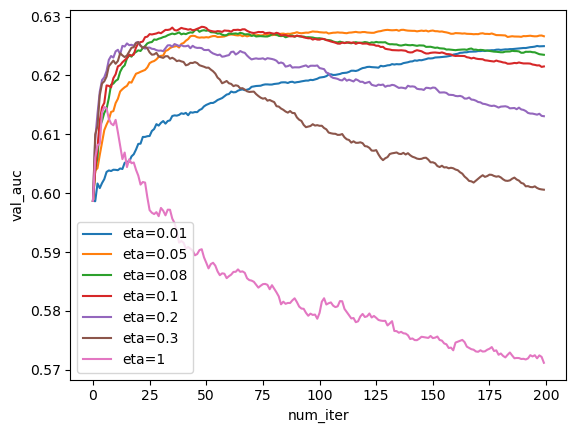

In [14]:
for key, df_scores in scores_eta.items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

**Conclusion**

Looking at the graph, `eta=0.1` seems to produce the best results. The peak auc_score of around 0.628 is reached after 48 iterations at this eta=0.1 (auc_score = 0.628275).

I have observed in practice, however, that sometimes, other eta values, especially the default (0.3), actually produce a better final score when other parameters are tuned.

For this reason, I will evaluate max_depth with multiple learning rates.

### What's the best max depth of the decision trees?

In [15]:
num_boost_round = 200

etas_to_test = [0.05,0.1, 0.2, 0.3]
max_depth_to_test = [3,4,5,6,8,12,20]


totals_max_depth = {}

for eta in tqdm(etas_to_test):
    scores_max_depth = {}
    for m_depth in tqdm(max_depth_to_test):
        xgb_params = {
            'booster': 'gbtree', # default
            'verbosity': 1, # default
            'nthread': 6, # how many cores/ how much parallelization, depends on your system

            'eta': eta, 
            'max_depth': m_depth,
            'min_child_weight': 1, # default

            'objective' :'binary:logistic', 
            'seed': 1, # random number seed to make the results reproducible
            'eval_metric': 'auc'
        }

        key = f'max_depth={m_depth}'
        scores_max_depth[key] = train_and_evaluate(xgb_params, num_boost_round)
    key = f'eta={eta}'
    totals_max_depth[key] = scores_max_depth

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.58169	val-auc:0.58651
[1]	train-auc:0.59528	val-auc:0.60087
[2]	train-auc:0.59294	val-auc:0.59803
[3]	train-auc:0.59397	val-auc:0.60120
[4]	train-auc:0.59397	val-auc:0.60102
[5]	train-auc:0.59325	val-auc:0.60025
[6]	train-auc:0.59623	val-auc:0.60302
[7]	train-auc:0.59866	val-auc:0.60431
[8]	train-auc:0.59844	val-auc:0.60524
[9]	train-auc:0.60016	val-auc:0.60596
[10]	train-auc:0.60015	val-auc:0.60598
[11]	train-auc:0.60060	val-auc:0.60630
[12]	train-auc:0.60054	val-auc:0.60628
[13]	train-auc:0.59989	val-auc:0.60655
[14]	train-auc:0.59999	val-auc:0.60660
[15]	train-auc:0.60066	val-auc:0.60716
[16]	train-auc:0.60137	val-auc:0.60821
[17]	train-auc:0.60232	val-auc:0.60835
[18]	train-auc:0.60285	val-auc:0.60898
[19]	train-auc:0.60269	val-auc:0.60880
[20]	train-auc:0.60273	val-auc:0.60907
[21]	train-auc:0.60261	val-auc:0.60906
[22]	train-auc:0.60355	val-auc:0.60998
[23]	train-auc:0.60356	val-auc:0.60996
[24]	train-auc:0.60438	val-auc:0.61081
[25]	train-auc:0.60450	val-auc:0.61

[8]	train-auc:0.60617	val-auc:0.60968
[9]	train-auc:0.60653	val-auc:0.60958
[10]	train-auc:0.60735	val-auc:0.61018
[11]	train-auc:0.60767	val-auc:0.61065
[12]	train-auc:0.60841	val-auc:0.61139
[13]	train-auc:0.60895	val-auc:0.61175
[14]	train-auc:0.60904	val-auc:0.61158
[15]	train-auc:0.60910	val-auc:0.61179
[16]	train-auc:0.60985	val-auc:0.61285
[17]	train-auc:0.61034	val-auc:0.61312
[18]	train-auc:0.61090	val-auc:0.61364
[19]	train-auc:0.61102	val-auc:0.61377
[20]	train-auc:0.61184	val-auc:0.61406
[21]	train-auc:0.61194	val-auc:0.61413
[22]	train-auc:0.61250	val-auc:0.61483
[23]	train-auc:0.61314	val-auc:0.61530
[24]	train-auc:0.61313	val-auc:0.61536
[25]	train-auc:0.61331	val-auc:0.61548
[26]	train-auc:0.61447	val-auc:0.61609
[27]	train-auc:0.61504	val-auc:0.61678
[28]	train-auc:0.61632	val-auc:0.61693
[29]	train-auc:0.61664	val-auc:0.61716
[30]	train-auc:0.61747	val-auc:0.61779
[31]	train-auc:0.61823	val-auc:0.61754
[32]	train-auc:0.61879	val-auc:0.61838
[33]	train-auc:0.61961	val-

[16]	train-auc:0.61737	val-auc:0.61572
[17]	train-auc:0.61830	val-auc:0.61633
[18]	train-auc:0.61839	val-auc:0.61622
[19]	train-auc:0.61969	val-auc:0.61689
[20]	train-auc:0.61994	val-auc:0.61711
[21]	train-auc:0.62127	val-auc:0.61781
[22]	train-auc:0.62218	val-auc:0.61822
[23]	train-auc:0.62295	val-auc:0.61850
[24]	train-auc:0.62329	val-auc:0.61887
[25]	train-auc:0.62384	val-auc:0.61936
[26]	train-auc:0.62455	val-auc:0.61968
[27]	train-auc:0.62521	val-auc:0.62003
[28]	train-auc:0.62555	val-auc:0.62037
[29]	train-auc:0.62686	val-auc:0.62067
[30]	train-auc:0.62750	val-auc:0.62120
[31]	train-auc:0.62849	val-auc:0.62104
[32]	train-auc:0.62955	val-auc:0.62161
[33]	train-auc:0.62983	val-auc:0.62177
[34]	train-auc:0.63067	val-auc:0.62200
[35]	train-auc:0.63128	val-auc:0.62243
[36]	train-auc:0.63204	val-auc:0.62287
[37]	train-auc:0.63266	val-auc:0.62320
[38]	train-auc:0.63334	val-auc:0.62356
[39]	train-auc:0.63420	val-auc:0.62357
[40]	train-auc:0.63467	val-auc:0.62373
[41]	train-auc:0.63520	va

[24]	train-auc:0.63644	val-auc:0.62137
[25]	train-auc:0.63772	val-auc:0.62209
[26]	train-auc:0.63841	val-auc:0.62233
[27]	train-auc:0.63897	val-auc:0.62246
[28]	train-auc:0.63967	val-auc:0.62274
[29]	train-auc:0.64028	val-auc:0.62316
[30]	train-auc:0.64095	val-auc:0.62334
[31]	train-auc:0.64165	val-auc:0.62338
[32]	train-auc:0.64268	val-auc:0.62416
[33]	train-auc:0.64296	val-auc:0.62432
[34]	train-auc:0.64381	val-auc:0.62465
[35]	train-auc:0.64531	val-auc:0.62485
[36]	train-auc:0.64599	val-auc:0.62492
[37]	train-auc:0.64638	val-auc:0.62502
[38]	train-auc:0.64740	val-auc:0.62475
[39]	train-auc:0.64868	val-auc:0.62537
[40]	train-auc:0.64913	val-auc:0.62552
[41]	train-auc:0.65014	val-auc:0.62591
[42]	train-auc:0.65093	val-auc:0.62618
[43]	train-auc:0.65242	val-auc:0.62666
[44]	train-auc:0.65298	val-auc:0.62675
[45]	train-auc:0.65341	val-auc:0.62670
[46]	train-auc:0.65426	val-auc:0.62650
[47]	train-auc:0.65508	val-auc:0.62643
[48]	train-auc:0.65582	val-auc:0.62647
[49]	train-auc:0.65656	va

[32]	train-auc:0.67798	val-auc:0.62142
[33]	train-auc:0.67871	val-auc:0.62179
[34]	train-auc:0.67915	val-auc:0.62201
[35]	train-auc:0.68104	val-auc:0.62251
[36]	train-auc:0.68129	val-auc:0.62259
[37]	train-auc:0.68288	val-auc:0.62247
[38]	train-auc:0.68395	val-auc:0.62265
[39]	train-auc:0.68461	val-auc:0.62296
[40]	train-auc:0.68585	val-auc:0.62297
[41]	train-auc:0.68707	val-auc:0.62301
[42]	train-auc:0.68811	val-auc:0.62324
[43]	train-auc:0.68899	val-auc:0.62331
[44]	train-auc:0.69046	val-auc:0.62340
[45]	train-auc:0.69152	val-auc:0.62377
[46]	train-auc:0.69264	val-auc:0.62374
[47]	train-auc:0.69425	val-auc:0.62369
[48]	train-auc:0.69483	val-auc:0.62365
[49]	train-auc:0.69602	val-auc:0.62350
[50]	train-auc:0.69679	val-auc:0.62339
[51]	train-auc:0.69819	val-auc:0.62364
[52]	train-auc:0.69849	val-auc:0.62381
[53]	train-auc:0.69931	val-auc:0.62382
[54]	train-auc:0.70073	val-auc:0.62378
[55]	train-auc:0.70144	val-auc:0.62384
[56]	train-auc:0.70224	val-auc:0.62387
[57]	train-auc:0.70278	va

[40]	train-auc:0.77775	val-auc:0.61480
[41]	train-auc:0.77942	val-auc:0.61495
[42]	train-auc:0.78070	val-auc:0.61508
[43]	train-auc:0.78192	val-auc:0.61500
[44]	train-auc:0.78310	val-auc:0.61513
[45]	train-auc:0.78424	val-auc:0.61530
[46]	train-auc:0.78610	val-auc:0.61535
[47]	train-auc:0.78807	val-auc:0.61522
[48]	train-auc:0.78891	val-auc:0.61543
[49]	train-auc:0.79045	val-auc:0.61563
[50]	train-auc:0.79204	val-auc:0.61560
[51]	train-auc:0.79340	val-auc:0.61563
[52]	train-auc:0.79491	val-auc:0.61564
[53]	train-auc:0.79610	val-auc:0.61530
[54]	train-auc:0.79680	val-auc:0.61519
[55]	train-auc:0.79893	val-auc:0.61497
[56]	train-auc:0.80056	val-auc:0.61497
[57]	train-auc:0.80189	val-auc:0.61495
[58]	train-auc:0.80320	val-auc:0.61466
[59]	train-auc:0.80408	val-auc:0.61439
[60]	train-auc:0.80515	val-auc:0.61452
[61]	train-auc:0.80566	val-auc:0.61459
[62]	train-auc:0.80660	val-auc:0.61478
[63]	train-auc:0.80792	val-auc:0.61495
[64]	train-auc:0.80926	val-auc:0.61475
[65]	train-auc:0.80983	va

[48]	train-auc:0.93266	val-auc:0.59700
[49]	train-auc:0.93356	val-auc:0.59739
[50]	train-auc:0.93466	val-auc:0.59719
[51]	train-auc:0.93593	val-auc:0.59728
[52]	train-auc:0.93683	val-auc:0.59738
[53]	train-auc:0.93804	val-auc:0.59760
[54]	train-auc:0.93902	val-auc:0.59744
[55]	train-auc:0.94086	val-auc:0.59746
[56]	train-auc:0.94189	val-auc:0.59725
[57]	train-auc:0.94322	val-auc:0.59747
[58]	train-auc:0.94461	val-auc:0.59746
[59]	train-auc:0.94588	val-auc:0.59745
[60]	train-auc:0.94719	val-auc:0.59753
[61]	train-auc:0.94841	val-auc:0.59730
[62]	train-auc:0.94936	val-auc:0.59747
[63]	train-auc:0.95042	val-auc:0.59743
[64]	train-auc:0.95164	val-auc:0.59744
[65]	train-auc:0.95304	val-auc:0.59762
[66]	train-auc:0.95389	val-auc:0.59753
[67]	train-auc:0.95471	val-auc:0.59735
[68]	train-auc:0.95532	val-auc:0.59745
[69]	train-auc:0.95628	val-auc:0.59714
[70]	train-auc:0.95676	val-auc:0.59717
[71]	train-auc:0.95747	val-auc:0.59695
[72]	train-auc:0.95872	val-auc:0.59697
[73]	train-auc:0.95921	va

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.58169	val-auc:0.58651
[1]	train-auc:0.59528	val-auc:0.60087
[2]	train-auc:0.59294	val-auc:0.59803
[3]	train-auc:0.59397	val-auc:0.60120
[4]	train-auc:0.59827	val-auc:0.60498
[5]	train-auc:0.59833	val-auc:0.60494
[6]	train-auc:0.59861	val-auc:0.60532
[7]	train-auc:0.59879	val-auc:0.60543
[8]	train-auc:0.60062	val-auc:0.60716
[9]	train-auc:0.60186	val-auc:0.60848
[10]	train-auc:0.60323	val-auc:0.60975
[11]	train-auc:0.60435	val-auc:0.61066
[12]	train-auc:0.60426	val-auc:0.61069
[13]	train-auc:0.60515	val-auc:0.61124
[14]	train-auc:0.60765	val-auc:0.61144
[15]	train-auc:0.60866	val-auc:0.61250
[16]	train-auc:0.60968	val-auc:0.61334
[17]	train-auc:0.60979	val-auc:0.61367
[18]	train-auc:0.61149	val-auc:0.61538
[19]	train-auc:0.61204	val-auc:0.61604
[20]	train-auc:0.61319	val-auc:0.61664
[21]	train-auc:0.61407	val-auc:0.61690
[22]	train-auc:0.61534	val-auc:0.61795
[23]	train-auc:0.61609	val-auc:0.61903
[24]	train-auc:0.61640	val-auc:0.61947
[25]	train-auc:0.61705	val-auc:0.61

[8]	train-auc:0.61021	val-auc:0.61340
[9]	train-auc:0.61132	val-auc:0.61386
[10]	train-auc:0.61200	val-auc:0.61449
[11]	train-auc:0.61238	val-auc:0.61508
[12]	train-auc:0.61322	val-auc:0.61532
[13]	train-auc:0.61489	val-auc:0.61622
[14]	train-auc:0.61675	val-auc:0.61650
[15]	train-auc:0.61837	val-auc:0.61805
[16]	train-auc:0.61984	val-auc:0.61909
[17]	train-auc:0.62102	val-auc:0.61883
[18]	train-auc:0.62179	val-auc:0.61902
[19]	train-auc:0.62303	val-auc:0.61955
[20]	train-auc:0.62474	val-auc:0.62051
[21]	train-auc:0.62572	val-auc:0.62103
[22]	train-auc:0.62634	val-auc:0.62165
[23]	train-auc:0.62733	val-auc:0.62219
[24]	train-auc:0.62838	val-auc:0.62292
[25]	train-auc:0.62937	val-auc:0.62320
[26]	train-auc:0.62985	val-auc:0.62385
[27]	train-auc:0.63053	val-auc:0.62378
[28]	train-auc:0.63118	val-auc:0.62432
[29]	train-auc:0.63182	val-auc:0.62455
[30]	train-auc:0.63284	val-auc:0.62480
[31]	train-auc:0.63370	val-auc:0.62528
[32]	train-auc:0.63467	val-auc:0.62544
[33]	train-auc:0.63530	val-

[16]	train-auc:0.62994	val-auc:0.62118
[17]	train-auc:0.63106	val-auc:0.62203
[18]	train-auc:0.63221	val-auc:0.62234
[19]	train-auc:0.63346	val-auc:0.62306
[20]	train-auc:0.63505	val-auc:0.62375
[21]	train-auc:0.63595	val-auc:0.62421
[22]	train-auc:0.63723	val-auc:0.62390
[23]	train-auc:0.63883	val-auc:0.62428
[24]	train-auc:0.64016	val-auc:0.62402
[25]	train-auc:0.64061	val-auc:0.62421
[26]	train-auc:0.64196	val-auc:0.62458
[27]	train-auc:0.64263	val-auc:0.62461
[28]	train-auc:0.64343	val-auc:0.62489
[29]	train-auc:0.64442	val-auc:0.62500
[30]	train-auc:0.64501	val-auc:0.62545
[31]	train-auc:0.64583	val-auc:0.62571
[32]	train-auc:0.64704	val-auc:0.62625
[33]	train-auc:0.64767	val-auc:0.62656
[34]	train-auc:0.64892	val-auc:0.62616
[35]	train-auc:0.64988	val-auc:0.62601
[36]	train-auc:0.65087	val-auc:0.62637
[37]	train-auc:0.65142	val-auc:0.62657
[38]	train-auc:0.65199	val-auc:0.62634
[39]	train-auc:0.65320	val-auc:0.62666
[40]	train-auc:0.65381	val-auc:0.62703
[41]	train-auc:0.65479	va

[24]	train-auc:0.65654	val-auc:0.62660
[25]	train-auc:0.65832	val-auc:0.62702
[26]	train-auc:0.65982	val-auc:0.62697
[27]	train-auc:0.66042	val-auc:0.62706
[28]	train-auc:0.66109	val-auc:0.62714
[29]	train-auc:0.66191	val-auc:0.62730
[30]	train-auc:0.66290	val-auc:0.62718
[31]	train-auc:0.66400	val-auc:0.62746
[32]	train-auc:0.66539	val-auc:0.62775
[33]	train-auc:0.66593	val-auc:0.62774
[34]	train-auc:0.66678	val-auc:0.62782
[35]	train-auc:0.66823	val-auc:0.62814
[36]	train-auc:0.66987	val-auc:0.62771
[37]	train-auc:0.67050	val-auc:0.62764
[38]	train-auc:0.67109	val-auc:0.62785
[39]	train-auc:0.67186	val-auc:0.62809
[40]	train-auc:0.67280	val-auc:0.62796
[41]	train-auc:0.67358	val-auc:0.62790
[42]	train-auc:0.67525	val-auc:0.62778
[43]	train-auc:0.67584	val-auc:0.62788
[44]	train-auc:0.67655	val-auc:0.62768
[45]	train-auc:0.67732	val-auc:0.62776
[46]	train-auc:0.67843	val-auc:0.62793
[47]	train-auc:0.67976	val-auc:0.62808
[48]	train-auc:0.68043	val-auc:0.62827
[49]	train-auc:0.68112	va

[32]	train-auc:0.70790	val-auc:0.62437
[33]	train-auc:0.70991	val-auc:0.62397
[34]	train-auc:0.71070	val-auc:0.62394
[35]	train-auc:0.71164	val-auc:0.62396
[36]	train-auc:0.71401	val-auc:0.62375
[37]	train-auc:0.71516	val-auc:0.62370
[38]	train-auc:0.71672	val-auc:0.62346
[39]	train-auc:0.71795	val-auc:0.62319
[40]	train-auc:0.71980	val-auc:0.62337
[41]	train-auc:0.72248	val-auc:0.62322
[42]	train-auc:0.72335	val-auc:0.62328
[43]	train-auc:0.72393	val-auc:0.62302
[44]	train-auc:0.72511	val-auc:0.62315
[45]	train-auc:0.72624	val-auc:0.62312
[46]	train-auc:0.72711	val-auc:0.62321
[47]	train-auc:0.72774	val-auc:0.62311
[48]	train-auc:0.72897	val-auc:0.62281
[49]	train-auc:0.73079	val-auc:0.62269
[50]	train-auc:0.73134	val-auc:0.62249
[51]	train-auc:0.73236	val-auc:0.62234
[52]	train-auc:0.73352	val-auc:0.62251
[53]	train-auc:0.73432	val-auc:0.62236
[54]	train-auc:0.73503	val-auc:0.62240
[55]	train-auc:0.73625	val-auc:0.62218
[56]	train-auc:0.73710	val-auc:0.62207
[57]	train-auc:0.73848	va

[40]	train-auc:0.82131	val-auc:0.61172
[41]	train-auc:0.82209	val-auc:0.61158
[42]	train-auc:0.82287	val-auc:0.61154
[43]	train-auc:0.82421	val-auc:0.61146
[44]	train-auc:0.82639	val-auc:0.61148
[45]	train-auc:0.82769	val-auc:0.61166
[46]	train-auc:0.82934	val-auc:0.61134
[47]	train-auc:0.83077	val-auc:0.61089
[48]	train-auc:0.83214	val-auc:0.61068
[49]	train-auc:0.83323	val-auc:0.61066
[50]	train-auc:0.83569	val-auc:0.61049
[51]	train-auc:0.83731	val-auc:0.61050
[52]	train-auc:0.83909	val-auc:0.61030
[53]	train-auc:0.84137	val-auc:0.60961
[54]	train-auc:0.84234	val-auc:0.60955
[55]	train-auc:0.84356	val-auc:0.60934
[56]	train-auc:0.84501	val-auc:0.60950
[57]	train-auc:0.84744	val-auc:0.60990
[58]	train-auc:0.84800	val-auc:0.60966
[59]	train-auc:0.84837	val-auc:0.60983
[60]	train-auc:0.84997	val-auc:0.60984
[61]	train-auc:0.85044	val-auc:0.60950
[62]	train-auc:0.85166	val-auc:0.60951
[63]	train-auc:0.85469	val-auc:0.60904
[64]	train-auc:0.85618	val-auc:0.60914
[65]	train-auc:0.85668	va

[48]	train-auc:0.97285	val-auc:0.59173
[49]	train-auc:0.97374	val-auc:0.59151
[50]	train-auc:0.97424	val-auc:0.59166
[51]	train-auc:0.97462	val-auc:0.59200
[52]	train-auc:0.97549	val-auc:0.59197
[53]	train-auc:0.97612	val-auc:0.59214
[54]	train-auc:0.97652	val-auc:0.59210
[55]	train-auc:0.97720	val-auc:0.59183
[56]	train-auc:0.97847	val-auc:0.59205
[57]	train-auc:0.97892	val-auc:0.59216
[58]	train-auc:0.98021	val-auc:0.59229
[59]	train-auc:0.98172	val-auc:0.59231
[60]	train-auc:0.98229	val-auc:0.59227
[61]	train-auc:0.98298	val-auc:0.59207
[62]	train-auc:0.98346	val-auc:0.59203
[63]	train-auc:0.98417	val-auc:0.59178
[64]	train-auc:0.98453	val-auc:0.59146
[65]	train-auc:0.98517	val-auc:0.59158
[66]	train-auc:0.98559	val-auc:0.59139
[67]	train-auc:0.98596	val-auc:0.59122
[68]	train-auc:0.98645	val-auc:0.59084
[69]	train-auc:0.98697	val-auc:0.59068
[70]	train-auc:0.98728	val-auc:0.59051
[71]	train-auc:0.98797	val-auc:0.59077
[72]	train-auc:0.98862	val-auc:0.59054
[73]	train-auc:0.98890	va

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.58169	val-auc:0.58651
[1]	train-auc:0.59527	val-auc:0.60087
[2]	train-auc:0.59882	val-auc:0.60405
[3]	train-auc:0.59879	val-auc:0.60551
[4]	train-auc:0.60018	val-auc:0.60616
[5]	train-auc:0.60273	val-auc:0.60935
[6]	train-auc:0.60457	val-auc:0.61072
[7]	train-auc:0.60612	val-auc:0.61102
[8]	train-auc:0.61031	val-auc:0.61603
[9]	train-auc:0.61148	val-auc:0.61673
[10]	train-auc:0.61342	val-auc:0.61795
[11]	train-auc:0.61520	val-auc:0.61943
[12]	train-auc:0.61689	val-auc:0.61986
[13]	train-auc:0.61791	val-auc:0.62060
[14]	train-auc:0.61942	val-auc:0.61996
[15]	train-auc:0.62069	val-auc:0.62034
[16]	train-auc:0.62151	val-auc:0.62058
[17]	train-auc:0.62292	val-auc:0.62154
[18]	train-auc:0.62378	val-auc:0.62223
[19]	train-auc:0.62517	val-auc:0.62185
[20]	train-auc:0.62626	val-auc:0.62278
[21]	train-auc:0.62665	val-auc:0.62289
[22]	train-auc:0.62771	val-auc:0.62309
[23]	train-auc:0.62838	val-auc:0.62325
[24]	train-auc:0.62903	val-auc:0.62379
[25]	train-auc:0.62934	val-auc:0.62

[8]	train-auc:0.61974	val-auc:0.61711
[9]	train-auc:0.62204	val-auc:0.61855
[10]	train-auc:0.62541	val-auc:0.62046
[11]	train-auc:0.62710	val-auc:0.62127
[12]	train-auc:0.62881	val-auc:0.62090
[13]	train-auc:0.63031	val-auc:0.62136
[14]	train-auc:0.63216	val-auc:0.62201
[15]	train-auc:0.63358	val-auc:0.62262
[16]	train-auc:0.63539	val-auc:0.62301
[17]	train-auc:0.63607	val-auc:0.62312
[18]	train-auc:0.63765	val-auc:0.62323
[19]	train-auc:0.63865	val-auc:0.62357
[20]	train-auc:0.64011	val-auc:0.62348
[21]	train-auc:0.64160	val-auc:0.62410
[22]	train-auc:0.64260	val-auc:0.62467
[23]	train-auc:0.64316	val-auc:0.62530
[24]	train-auc:0.64409	val-auc:0.62529
[25]	train-auc:0.64487	val-auc:0.62551
[26]	train-auc:0.64600	val-auc:0.62625
[27]	train-auc:0.64681	val-auc:0.62639
[28]	train-auc:0.64744	val-auc:0.62616
[29]	train-auc:0.64854	val-auc:0.62627
[30]	train-auc:0.64927	val-auc:0.62603
[31]	train-auc:0.64997	val-auc:0.62614
[32]	train-auc:0.65084	val-auc:0.62612
[33]	train-auc:0.65159	val-

[16]	train-auc:0.64975	val-auc:0.62581
[17]	train-auc:0.65168	val-auc:0.62533
[18]	train-auc:0.65319	val-auc:0.62536
[19]	train-auc:0.65488	val-auc:0.62546
[20]	train-auc:0.65657	val-auc:0.62572
[21]	train-auc:0.65716	val-auc:0.62593
[22]	train-auc:0.65858	val-auc:0.62557
[23]	train-auc:0.66005	val-auc:0.62566
[24]	train-auc:0.66185	val-auc:0.62576
[25]	train-auc:0.66361	val-auc:0.62583
[26]	train-auc:0.66503	val-auc:0.62620
[27]	train-auc:0.66604	val-auc:0.62660
[28]	train-auc:0.66695	val-auc:0.62666
[29]	train-auc:0.66835	val-auc:0.62672
[30]	train-auc:0.66950	val-auc:0.62667
[31]	train-auc:0.67011	val-auc:0.62696
[32]	train-auc:0.67144	val-auc:0.62716
[33]	train-auc:0.67230	val-auc:0.62715
[34]	train-auc:0.67358	val-auc:0.62686
[35]	train-auc:0.67437	val-auc:0.62678
[36]	train-auc:0.67595	val-auc:0.62695
[37]	train-auc:0.67659	val-auc:0.62685
[38]	train-auc:0.67685	val-auc:0.62700
[39]	train-auc:0.67776	val-auc:0.62666
[40]	train-auc:0.67882	val-auc:0.62571
[41]	train-auc:0.67969	va

[24]	train-auc:0.68040	val-auc:0.62472
[25]	train-auc:0.68152	val-auc:0.62474
[26]	train-auc:0.68350	val-auc:0.62453
[27]	train-auc:0.68503	val-auc:0.62449
[28]	train-auc:0.68587	val-auc:0.62430
[29]	train-auc:0.68733	val-auc:0.62421
[30]	train-auc:0.68916	val-auc:0.62424
[31]	train-auc:0.68997	val-auc:0.62413
[32]	train-auc:0.69148	val-auc:0.62463
[33]	train-auc:0.69279	val-auc:0.62512
[34]	train-auc:0.69380	val-auc:0.62514
[35]	train-auc:0.69474	val-auc:0.62490
[36]	train-auc:0.69530	val-auc:0.62534
[37]	train-auc:0.69631	val-auc:0.62517
[38]	train-auc:0.69732	val-auc:0.62502
[39]	train-auc:0.69777	val-auc:0.62515
[40]	train-auc:0.69886	val-auc:0.62497
[41]	train-auc:0.70065	val-auc:0.62497
[42]	train-auc:0.70195	val-auc:0.62508
[43]	train-auc:0.70275	val-auc:0.62463
[44]	train-auc:0.70504	val-auc:0.62504
[45]	train-auc:0.70612	val-auc:0.62478
[46]	train-auc:0.70669	val-auc:0.62468
[47]	train-auc:0.70757	val-auc:0.62470
[48]	train-auc:0.70851	val-auc:0.62465
[49]	train-auc:0.70930	va

[32]	train-auc:0.74210	val-auc:0.62057
[33]	train-auc:0.74310	val-auc:0.62045
[34]	train-auc:0.74397	val-auc:0.62019
[35]	train-auc:0.74543	val-auc:0.61983
[36]	train-auc:0.74783	val-auc:0.61943
[37]	train-auc:0.74960	val-auc:0.61893
[38]	train-auc:0.75154	val-auc:0.61875
[39]	train-auc:0.75400	val-auc:0.61929
[40]	train-auc:0.75594	val-auc:0.61952
[41]	train-auc:0.75763	val-auc:0.62011
[42]	train-auc:0.75899	val-auc:0.61977
[43]	train-auc:0.76029	val-auc:0.61970
[44]	train-auc:0.76260	val-auc:0.61935
[45]	train-auc:0.76347	val-auc:0.61943
[46]	train-auc:0.76517	val-auc:0.61953
[47]	train-auc:0.76650	val-auc:0.61975
[48]	train-auc:0.76738	val-auc:0.61963
[49]	train-auc:0.76905	val-auc:0.61937
[50]	train-auc:0.77194	val-auc:0.61843
[51]	train-auc:0.77415	val-auc:0.61873
[52]	train-auc:0.77598	val-auc:0.61883
[53]	train-auc:0.77843	val-auc:0.61843
[54]	train-auc:0.77878	val-auc:0.61845
[55]	train-auc:0.78028	val-auc:0.61838
[56]	train-auc:0.78146	val-auc:0.61863
[57]	train-auc:0.78225	va

[40]	train-auc:0.87490	val-auc:0.60263
[41]	train-auc:0.87709	val-auc:0.60214
[42]	train-auc:0.87809	val-auc:0.60175
[43]	train-auc:0.87956	val-auc:0.60191
[44]	train-auc:0.88197	val-auc:0.60186
[45]	train-auc:0.88379	val-auc:0.60155
[46]	train-auc:0.88609	val-auc:0.60167
[47]	train-auc:0.88981	val-auc:0.60129
[48]	train-auc:0.89128	val-auc:0.60084
[49]	train-auc:0.89425	val-auc:0.60068
[50]	train-auc:0.89746	val-auc:0.59964
[51]	train-auc:0.89981	val-auc:0.59948
[52]	train-auc:0.90102	val-auc:0.59931
[53]	train-auc:0.90347	val-auc:0.59895
[54]	train-auc:0.90441	val-auc:0.59914
[55]	train-auc:0.90562	val-auc:0.59934
[56]	train-auc:0.90798	val-auc:0.59938
[57]	train-auc:0.90938	val-auc:0.59942
[58]	train-auc:0.91053	val-auc:0.59969
[59]	train-auc:0.91254	val-auc:0.59961
[60]	train-auc:0.91354	val-auc:0.59936
[61]	train-auc:0.91561	val-auc:0.59875
[62]	train-auc:0.91699	val-auc:0.59885
[63]	train-auc:0.91807	val-auc:0.59898
[64]	train-auc:0.91913	val-auc:0.59853
[65]	train-auc:0.92006	va

[48]	train-auc:0.99258	val-auc:0.58583
[49]	train-auc:0.99326	val-auc:0.58617
[50]	train-auc:0.99386	val-auc:0.58523
[51]	train-auc:0.99415	val-auc:0.58515
[52]	train-auc:0.99454	val-auc:0.58474
[53]	train-auc:0.99512	val-auc:0.58495
[54]	train-auc:0.99557	val-auc:0.58438
[55]	train-auc:0.99590	val-auc:0.58417
[56]	train-auc:0.99634	val-auc:0.58449
[57]	train-auc:0.99652	val-auc:0.58452
[58]	train-auc:0.99663	val-auc:0.58438
[59]	train-auc:0.99685	val-auc:0.58413
[60]	train-auc:0.99710	val-auc:0.58336
[61]	train-auc:0.99741	val-auc:0.58313
[62]	train-auc:0.99776	val-auc:0.58306
[63]	train-auc:0.99791	val-auc:0.58275
[64]	train-auc:0.99796	val-auc:0.58267
[65]	train-auc:0.99812	val-auc:0.58236
[66]	train-auc:0.99820	val-auc:0.58217
[67]	train-auc:0.99827	val-auc:0.58187
[68]	train-auc:0.99836	val-auc:0.58162
[69]	train-auc:0.99847	val-auc:0.58116
[70]	train-auc:0.99861	val-auc:0.58099
[71]	train-auc:0.99865	val-auc:0.58075
[72]	train-auc:0.99874	val-auc:0.58096
[73]	train-auc:0.99883	va

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-auc:0.58169	val-auc:0.58651
[1]	train-auc:0.59591	val-auc:0.60189
[2]	train-auc:0.60069	val-auc:0.60565
[3]	train-auc:0.60112	val-auc:0.60615
[4]	train-auc:0.60453	val-auc:0.60871
[5]	train-auc:0.60940	val-auc:0.61019
[6]	train-auc:0.61096	val-auc:0.61161
[7]	train-auc:0.61465	val-auc:0.61622
[8]	train-auc:0.61726	val-auc:0.61846
[9]	train-auc:0.61873	val-auc:0.62000
[10]	train-auc:0.62088	val-auc:0.62090
[11]	train-auc:0.62192	val-auc:0.62120
[12]	train-auc:0.62384	val-auc:0.62212
[13]	train-auc:0.62563	val-auc:0.62213
[14]	train-auc:0.62713	val-auc:0.62343
[15]	train-auc:0.62854	val-auc:0.62378
[16]	train-auc:0.62987	val-auc:0.62527
[17]	train-auc:0.63131	val-auc:0.62574
[18]	train-auc:0.63175	val-auc:0.62610
[19]	train-auc:0.63293	val-auc:0.62611
[20]	train-auc:0.63400	val-auc:0.62559
[21]	train-auc:0.63473	val-auc:0.62553
[22]	train-auc:0.63545	val-auc:0.62596
[23]	train-auc:0.63634	val-auc:0.62647
[24]	train-auc:0.63714	val-auc:0.62720
[25]	train-auc:0.63791	val-auc:0.62

[8]	train-auc:0.62795	val-auc:0.62191
[9]	train-auc:0.63005	val-auc:0.62355
[10]	train-auc:0.63297	val-auc:0.62341
[11]	train-auc:0.63432	val-auc:0.62386
[12]	train-auc:0.63674	val-auc:0.62583
[13]	train-auc:0.63796	val-auc:0.62624
[14]	train-auc:0.63944	val-auc:0.62581
[15]	train-auc:0.64132	val-auc:0.62711
[16]	train-auc:0.64306	val-auc:0.62757
[17]	train-auc:0.64477	val-auc:0.62767
[18]	train-auc:0.64599	val-auc:0.62815
[19]	train-auc:0.64808	val-auc:0.62811
[20]	train-auc:0.64912	val-auc:0.62875
[21]	train-auc:0.65028	val-auc:0.62875
[22]	train-auc:0.65115	val-auc:0.62888
[23]	train-auc:0.65166	val-auc:0.62866
[24]	train-auc:0.65306	val-auc:0.62932
[25]	train-auc:0.65395	val-auc:0.62953
[26]	train-auc:0.65566	val-auc:0.62903
[27]	train-auc:0.65656	val-auc:0.62862
[28]	train-auc:0.65726	val-auc:0.62892
[29]	train-auc:0.65844	val-auc:0.62966
[30]	train-auc:0.65889	val-auc:0.63006
[31]	train-auc:0.66027	val-auc:0.63038
[32]	train-auc:0.66117	val-auc:0.63038
[33]	train-auc:0.66181	val-

[16]	train-auc:0.65775	val-auc:0.62636
[17]	train-auc:0.66018	val-auc:0.62538
[18]	train-auc:0.66148	val-auc:0.62551
[19]	train-auc:0.66419	val-auc:0.62564
[20]	train-auc:0.66565	val-auc:0.62503
[21]	train-auc:0.66743	val-auc:0.62568
[22]	train-auc:0.66853	val-auc:0.62530
[23]	train-auc:0.66976	val-auc:0.62503
[24]	train-auc:0.67053	val-auc:0.62548
[25]	train-auc:0.67225	val-auc:0.62546
[26]	train-auc:0.67281	val-auc:0.62506
[27]	train-auc:0.67478	val-auc:0.62485
[28]	train-auc:0.67581	val-auc:0.62511
[29]	train-auc:0.67749	val-auc:0.62525
[30]	train-auc:0.67983	val-auc:0.62473
[31]	train-auc:0.68064	val-auc:0.62421
[32]	train-auc:0.68199	val-auc:0.62376
[33]	train-auc:0.68290	val-auc:0.62382
[34]	train-auc:0.68378	val-auc:0.62331
[35]	train-auc:0.68572	val-auc:0.62321
[36]	train-auc:0.68652	val-auc:0.62337
[37]	train-auc:0.68705	val-auc:0.62341
[38]	train-auc:0.68801	val-auc:0.62343
[39]	train-auc:0.68850	val-auc:0.62331
[40]	train-auc:0.68967	val-auc:0.62337
[41]	train-auc:0.69129	va

[24]	train-auc:0.69869	val-auc:0.62461
[25]	train-auc:0.70019	val-auc:0.62393
[26]	train-auc:0.70146	val-auc:0.62353
[27]	train-auc:0.70227	val-auc:0.62358
[28]	train-auc:0.70438	val-auc:0.62384
[29]	train-auc:0.70514	val-auc:0.62325
[30]	train-auc:0.70627	val-auc:0.62310
[31]	train-auc:0.70736	val-auc:0.62299
[32]	train-auc:0.70788	val-auc:0.62327
[33]	train-auc:0.70931	val-auc:0.62328
[34]	train-auc:0.71053	val-auc:0.62285
[35]	train-auc:0.71274	val-auc:0.62301
[36]	train-auc:0.71357	val-auc:0.62279
[37]	train-auc:0.71448	val-auc:0.62244
[38]	train-auc:0.71546	val-auc:0.62255
[39]	train-auc:0.71786	val-auc:0.62240
[40]	train-auc:0.71918	val-auc:0.62229
[41]	train-auc:0.72040	val-auc:0.62173
[42]	train-auc:0.72179	val-auc:0.62186
[43]	train-auc:0.72322	val-auc:0.62214
[44]	train-auc:0.72423	val-auc:0.62212
[45]	train-auc:0.72525	val-auc:0.62227
[46]	train-auc:0.72663	val-auc:0.62211
[47]	train-auc:0.72820	val-auc:0.62174
[48]	train-auc:0.72965	val-auc:0.62161
[49]	train-auc:0.72999	va

[32]	train-auc:0.76256	val-auc:0.61336
[33]	train-auc:0.76590	val-auc:0.61307
[34]	train-auc:0.76967	val-auc:0.61224
[35]	train-auc:0.77227	val-auc:0.61212
[36]	train-auc:0.77451	val-auc:0.61141
[37]	train-auc:0.77916	val-auc:0.61178
[38]	train-auc:0.78126	val-auc:0.61122
[39]	train-auc:0.78228	val-auc:0.61094
[40]	train-auc:0.78380	val-auc:0.61099
[41]	train-auc:0.78708	val-auc:0.61029
[42]	train-auc:0.78796	val-auc:0.60978
[43]	train-auc:0.79024	val-auc:0.60979
[44]	train-auc:0.79212	val-auc:0.60964
[45]	train-auc:0.79567	val-auc:0.60953
[46]	train-auc:0.79721	val-auc:0.60910
[47]	train-auc:0.79941	val-auc:0.60922
[48]	train-auc:0.80188	val-auc:0.60865
[49]	train-auc:0.80425	val-auc:0.60898
[50]	train-auc:0.80713	val-auc:0.60834
[51]	train-auc:0.80945	val-auc:0.60826
[52]	train-auc:0.81035	val-auc:0.60839
[53]	train-auc:0.81158	val-auc:0.60836
[54]	train-auc:0.81340	val-auc:0.60817
[55]	train-auc:0.81642	val-auc:0.60761
[56]	train-auc:0.81812	val-auc:0.60772
[57]	train-auc:0.81976	va

[40]	train-auc:0.91202	val-auc:0.59721
[41]	train-auc:0.91320	val-auc:0.59667
[42]	train-auc:0.91536	val-auc:0.59630
[43]	train-auc:0.91681	val-auc:0.59639
[44]	train-auc:0.91939	val-auc:0.59618
[45]	train-auc:0.92101	val-auc:0.59459
[46]	train-auc:0.92200	val-auc:0.59482
[47]	train-auc:0.92386	val-auc:0.59459
[48]	train-auc:0.92678	val-auc:0.59378
[49]	train-auc:0.93005	val-auc:0.59349
[50]	train-auc:0.93085	val-auc:0.59304
[51]	train-auc:0.93245	val-auc:0.59288
[52]	train-auc:0.93483	val-auc:0.59206
[53]	train-auc:0.93574	val-auc:0.59162
[54]	train-auc:0.93888	val-auc:0.59160
[55]	train-auc:0.94077	val-auc:0.59064
[56]	train-auc:0.94181	val-auc:0.59077
[57]	train-auc:0.94239	val-auc:0.59050
[58]	train-auc:0.94375	val-auc:0.58991
[59]	train-auc:0.94447	val-auc:0.58982
[60]	train-auc:0.94536	val-auc:0.58949
[61]	train-auc:0.94599	val-auc:0.58928
[62]	train-auc:0.94715	val-auc:0.58878
[63]	train-auc:0.94932	val-auc:0.58900
[64]	train-auc:0.95038	val-auc:0.58879
[65]	train-auc:0.95162	va

[48]	train-auc:0.99788	val-auc:0.57759
[49]	train-auc:0.99805	val-auc:0.57777
[50]	train-auc:0.99817	val-auc:0.57770
[51]	train-auc:0.99839	val-auc:0.57752
[52]	train-auc:0.99859	val-auc:0.57769
[53]	train-auc:0.99864	val-auc:0.57776
[54]	train-auc:0.99880	val-auc:0.57756
[55]	train-auc:0.99888	val-auc:0.57717
[56]	train-auc:0.99916	val-auc:0.57748
[57]	train-auc:0.99928	val-auc:0.57697
[58]	train-auc:0.99933	val-auc:0.57672
[59]	train-auc:0.99942	val-auc:0.57660
[60]	train-auc:0.99946	val-auc:0.57633
[61]	train-auc:0.99954	val-auc:0.57601
[62]	train-auc:0.99958	val-auc:0.57557
[63]	train-auc:0.99963	val-auc:0.57507
[64]	train-auc:0.99967	val-auc:0.57466
[65]	train-auc:0.99969	val-auc:0.57449
[66]	train-auc:0.99971	val-auc:0.57397
[67]	train-auc:0.99972	val-auc:0.57402
[68]	train-auc:0.99973	val-auc:0.57411
[69]	train-auc:0.99975	val-auc:0.57438
[70]	train-auc:0.99977	val-auc:0.57429
[71]	train-auc:0.99980	val-auc:0.57460
[72]	train-auc:0.99982	val-auc:0.57497
[73]	train-auc:0.99983	va

In [16]:
totals_max_depth.keys()

dict_keys(['eta=0.05', 'eta=0.1', 'eta=0.2', 'eta=0.3'])

**Observations**

For all `etas`, the best `max_depth` looks to be 3 or 4.

All `etas` manage to hit a new high of 0.63 but do so at different times: the quickest is `eta=0.3` when `max_depth` is 4 after 33 iterations.


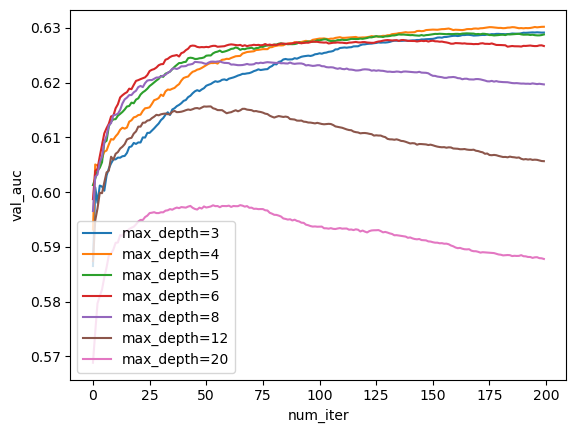

In [18]:
eta= 0.05

for key, df_scores in totals_max_depth[f'eta={eta}'].items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

In [24]:
totals_max_depth[f'eta=0.05']['max_depth=4'].sort_values(by="val_auc", ascending=False).head()

,num_iter,train_auc,val_auc
199,199,0.660467,0.630177
198,198,0.660261,0.630166
195,195,0.659934,0.630136
197,197,0.660140,0.630119
175,175,0.657475,0.630111


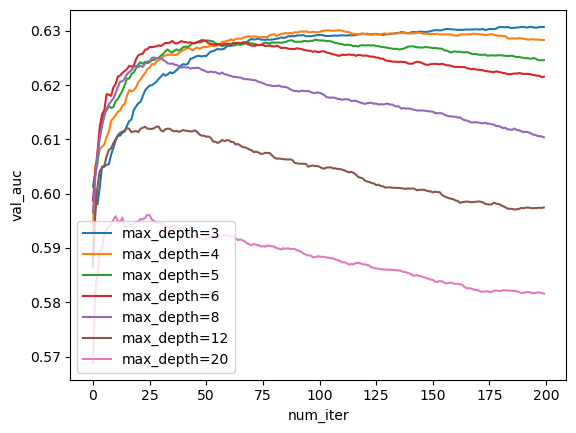

In [19]:
eta= 0.1

for key, df_scores in totals_max_depth[f'eta={eta}'].items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

In [28]:
totals_max_depth[f'eta=0.1']['max_depth=3'].sort_values(by="val_auc", ascending=False).head()

,num_iter,train_auc,val_auc
193,193,0.655305,0.630730
199,199,0.655902,0.630708
183,183,0.654051,0.630704
180,180,0.653694,0.630697
190,190,0.654996,0.630695


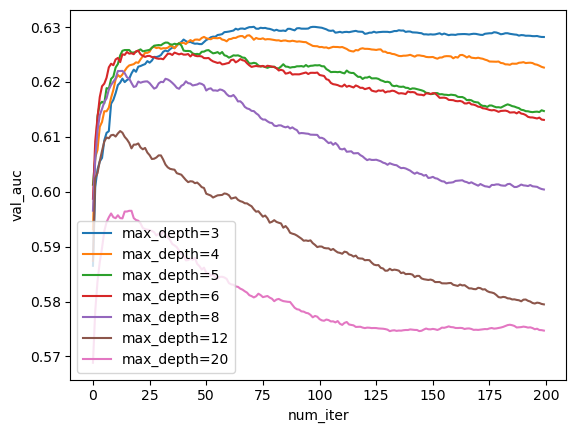

In [20]:
eta= 0.2

for key, df_scores in totals_max_depth[f'eta={eta}'].items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

In [29]:
totals_max_depth[f'eta=0.2']['max_depth=3'].sort_values(by="val_auc", ascending=False).head()

,num_iter,train_auc,val_auc
71,71,0.649214,0.630041
97,97,0.654940,0.630029
98,98,0.655369,0.630020
70,70,0.649062,0.629980
69,69,0.648785,0.629971


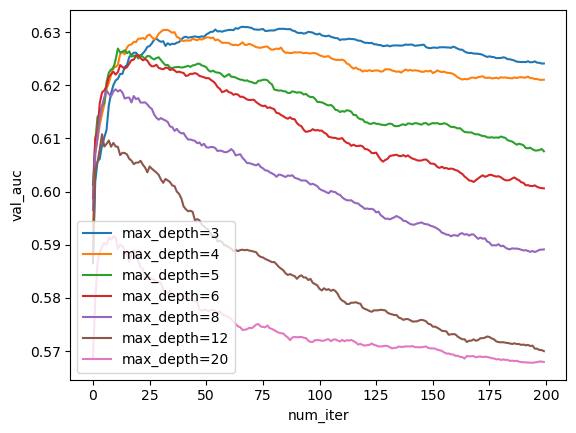

In [21]:
eta= 0.3

for key, df_scores in totals_max_depth[f'eta={eta}'].items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)
    
plt.show()

In [35]:
totals_max_depth[f'eta=0.3']['max_depth=3'].sort_values(by="val_auc", ascending=False).head()

,num_iter,train_auc,val_auc
66,66,0.657463,0.630983
68,68,0.657642,0.630938
67,67,0.657586,0.630933
65,65,0.657188,0.630881
69,69,0.657828,0.630864


**Conclusion**

Setting `eta=0.3` and `max_depth=4` provides a score of `0.630397` after 33 iterations.  

If we set `eta=0.3` and `max_depth=3` we achieve a score of `0.630983` but only after 66 iterations. 

The advice from the lectures is to choose a model that doesn't need too many iterations while still having good performance. We should prefer a higher peak at lower iterations. 

Taking this advice, I'll choose `eta=0.3` and `max_depth=4`.

### What's the minimum child weight we should use?

`min_child_weight` is similar to `min_leaf_node` in RandomForest but it does not specify a minimum number of observations but the minimum “sum of weights” of observations. Higher values are associated with less overfitting. 

In [36]:
num_boost_round = 200

eta = 0.3
max_depth = 4
min_child_weight_to_test = [1,2,3,4,5,10,20,50]

scores_min_child_weight = {}

for min_child in tqdm(min_child_weight_to_test):
    xgb_params = {
        'booster': 'gbtree', # default
        'verbosity': 1, # default
        'nthread': 6, # how many cores/ how much parallelization, depends on your system
    
        'eta': eta, 
        'max_depth': max_depth,
        'min_child_weight': min_child,
    
        'objective' :'binary:logistic', 
        'seed': 1, # random number seed to make the results reproducible
        'eval_metric': 'auc'
    }

    key = f'min_child_weight={min_child}'
    scores_min_child_weight[key] = train_and_evaluate(xgb_params, num_boost_round)

  0%|          | 0/8 [00:00<?, ?it/s]

[0]	train-auc:0.59216	val-auc:0.59315
[1]	train-auc:0.60377	val-auc:0.60715
[2]	train-auc:0.60809	val-auc:0.60972
[3]	train-auc:0.61025	val-auc:0.61255
[4]	train-auc:0.61303	val-auc:0.61454
[5]	train-auc:0.61709	val-auc:0.61633
[6]	train-auc:0.62131	val-auc:0.61932
[7]	train-auc:0.62556	val-auc:0.62045
[8]	train-auc:0.62795	val-auc:0.62191
[9]	train-auc:0.63005	val-auc:0.62355
[10]	train-auc:0.63297	val-auc:0.62341
[11]	train-auc:0.63432	val-auc:0.62386
[12]	train-auc:0.63674	val-auc:0.62583
[13]	train-auc:0.63796	val-auc:0.62624
[14]	train-auc:0.63944	val-auc:0.62581
[15]	train-auc:0.64132	val-auc:0.62711
[16]	train-auc:0.64306	val-auc:0.62757
[17]	train-auc:0.64477	val-auc:0.62767
[18]	train-auc:0.64599	val-auc:0.62815
[19]	train-auc:0.64808	val-auc:0.62811
[20]	train-auc:0.64912	val-auc:0.62875
[21]	train-auc:0.65028	val-auc:0.62875
[22]	train-auc:0.65115	val-auc:0.62888
[23]	train-auc:0.65166	val-auc:0.62866
[24]	train-auc:0.65306	val-auc:0.62932
[25]	train-auc:0.65395	val-auc:0.62

[8]	train-auc:0.62771	val-auc:0.62167
[9]	train-auc:0.62963	val-auc:0.62326
[10]	train-auc:0.63250	val-auc:0.62311
[11]	train-auc:0.63353	val-auc:0.62372
[12]	train-auc:0.63605	val-auc:0.62564
[13]	train-auc:0.63734	val-auc:0.62585
[14]	train-auc:0.63885	val-auc:0.62538
[15]	train-auc:0.64074	val-auc:0.62669
[16]	train-auc:0.64314	val-auc:0.62754
[17]	train-auc:0.64422	val-auc:0.62771
[18]	train-auc:0.64612	val-auc:0.62814
[19]	train-auc:0.64777	val-auc:0.62875
[20]	train-auc:0.64953	val-auc:0.62845
[21]	train-auc:0.65063	val-auc:0.62783
[22]	train-auc:0.65188	val-auc:0.62821
[23]	train-auc:0.65296	val-auc:0.62756
[24]	train-auc:0.65384	val-auc:0.62786
[25]	train-auc:0.65447	val-auc:0.62801
[26]	train-auc:0.65595	val-auc:0.62798
[27]	train-auc:0.65630	val-auc:0.62833
[28]	train-auc:0.65776	val-auc:0.62807
[29]	train-auc:0.65842	val-auc:0.62799
[30]	train-auc:0.65939	val-auc:0.62748
[31]	train-auc:0.66065	val-auc:0.62835
[32]	train-auc:0.66144	val-auc:0.62852
[33]	train-auc:0.66209	val-

[16]	train-auc:0.64104	val-auc:0.62777
[17]	train-auc:0.64244	val-auc:0.62831
[18]	train-auc:0.64423	val-auc:0.62852
[19]	train-auc:0.64505	val-auc:0.62863
[20]	train-auc:0.64648	val-auc:0.62875
[21]	train-auc:0.64794	val-auc:0.62874
[22]	train-auc:0.64902	val-auc:0.62823
[23]	train-auc:0.65002	val-auc:0.62900
[24]	train-auc:0.65156	val-auc:0.62935
[25]	train-auc:0.65209	val-auc:0.62857
[26]	train-auc:0.65314	val-auc:0.62839
[27]	train-auc:0.65410	val-auc:0.62851
[28]	train-auc:0.65494	val-auc:0.62840
[29]	train-auc:0.65526	val-auc:0.62853
[30]	train-auc:0.65565	val-auc:0.62850
[31]	train-auc:0.65686	val-auc:0.62857
[32]	train-auc:0.65752	val-auc:0.62902
[33]	train-auc:0.65850	val-auc:0.62843
[34]	train-auc:0.65920	val-auc:0.62830
[35]	train-auc:0.65985	val-auc:0.62770
[36]	train-auc:0.66069	val-auc:0.62796
[37]	train-auc:0.66133	val-auc:0.62778
[38]	train-auc:0.66164	val-auc:0.62773
[39]	train-auc:0.66251	val-auc:0.62760
[40]	train-auc:0.66314	val-auc:0.62799
[41]	train-auc:0.66381	va

[24]	train-auc:0.65135	val-auc:0.62857
[25]	train-auc:0.65198	val-auc:0.62850
[26]	train-auc:0.65359	val-auc:0.62726
[27]	train-auc:0.65443	val-auc:0.62738
[28]	train-auc:0.65544	val-auc:0.62716
[29]	train-auc:0.65643	val-auc:0.62704
[30]	train-auc:0.65761	val-auc:0.62682
[31]	train-auc:0.65802	val-auc:0.62724
[32]	train-auc:0.65907	val-auc:0.62794
[33]	train-auc:0.65981	val-auc:0.62837
[34]	train-auc:0.66089	val-auc:0.62858
[35]	train-auc:0.66118	val-auc:0.62846
[36]	train-auc:0.66167	val-auc:0.62858
[37]	train-auc:0.66236	val-auc:0.62835
[38]	train-auc:0.66316	val-auc:0.62866
[39]	train-auc:0.66385	val-auc:0.62859
[40]	train-auc:0.66440	val-auc:0.62889
[41]	train-auc:0.66486	val-auc:0.62859
[42]	train-auc:0.66564	val-auc:0.62886
[43]	train-auc:0.66596	val-auc:0.62885
[44]	train-auc:0.66674	val-auc:0.62858
[45]	train-auc:0.66738	val-auc:0.62843
[46]	train-auc:0.66749	val-auc:0.62861
[47]	train-auc:0.66808	val-auc:0.62832
[48]	train-auc:0.66893	val-auc:0.62825
[49]	train-auc:0.66953	va

[32]	train-auc:0.65672	val-auc:0.63079
[33]	train-auc:0.65751	val-auc:0.63036
[34]	train-auc:0.65818	val-auc:0.63018
[35]	train-auc:0.65861	val-auc:0.63050
[36]	train-auc:0.65903	val-auc:0.63053
[37]	train-auc:0.65977	val-auc:0.63070
[38]	train-auc:0.66075	val-auc:0.63024
[39]	train-auc:0.66158	val-auc:0.63046
[40]	train-auc:0.66219	val-auc:0.63006
[41]	train-auc:0.66268	val-auc:0.63036
[42]	train-auc:0.66336	val-auc:0.63068
[43]	train-auc:0.66393	val-auc:0.63084
[44]	train-auc:0.66432	val-auc:0.63080
[45]	train-auc:0.66524	val-auc:0.63016
[46]	train-auc:0.66578	val-auc:0.63027
[47]	train-auc:0.66645	val-auc:0.63016
[48]	train-auc:0.66650	val-auc:0.63000
[49]	train-auc:0.66716	val-auc:0.62957
[50]	train-auc:0.66778	val-auc:0.62985
[51]	train-auc:0.66839	val-auc:0.63000
[52]	train-auc:0.66872	val-auc:0.62980
[53]	train-auc:0.66939	val-auc:0.62954
[54]	train-auc:0.66985	val-auc:0.62948
[55]	train-auc:0.67022	val-auc:0.62959
[56]	train-auc:0.67036	val-auc:0.62968
[57]	train-auc:0.67062	va

[40]	train-auc:0.66021	val-auc:0.62908
[41]	train-auc:0.66079	val-auc:0.62874
[42]	train-auc:0.66174	val-auc:0.62805
[43]	train-auc:0.66280	val-auc:0.62841
[44]	train-auc:0.66313	val-auc:0.62800
[45]	train-auc:0.66353	val-auc:0.62806
[46]	train-auc:0.66376	val-auc:0.62814
[47]	train-auc:0.66441	val-auc:0.62777
[48]	train-auc:0.66490	val-auc:0.62797
[49]	train-auc:0.66587	val-auc:0.62806
[50]	train-auc:0.66645	val-auc:0.62777
[51]	train-auc:0.66716	val-auc:0.62809
[52]	train-auc:0.66746	val-auc:0.62807
[53]	train-auc:0.66806	val-auc:0.62768
[54]	train-auc:0.66849	val-auc:0.62786
[55]	train-auc:0.66886	val-auc:0.62802
[56]	train-auc:0.66928	val-auc:0.62787
[57]	train-auc:0.66972	val-auc:0.62768
[58]	train-auc:0.67045	val-auc:0.62754
[59]	train-auc:0.67092	val-auc:0.62788
[60]	train-auc:0.67131	val-auc:0.62783
[61]	train-auc:0.67191	val-auc:0.62791
[62]	train-auc:0.67247	val-auc:0.62752
[63]	train-auc:0.67322	val-auc:0.62748
[64]	train-auc:0.67354	val-auc:0.62744
[65]	train-auc:0.67399	va

[48]	train-auc:0.65738	val-auc:0.62955
[49]	train-auc:0.65834	val-auc:0.62913
[50]	train-auc:0.65898	val-auc:0.62925
[51]	train-auc:0.65922	val-auc:0.62925
[52]	train-auc:0.65978	val-auc:0.62948
[53]	train-auc:0.66023	val-auc:0.62904
[54]	train-auc:0.66049	val-auc:0.62902
[55]	train-auc:0.66067	val-auc:0.62927
[56]	train-auc:0.66079	val-auc:0.62924
[57]	train-auc:0.66124	val-auc:0.62904
[58]	train-auc:0.66178	val-auc:0.62918
[59]	train-auc:0.66223	val-auc:0.62873
[60]	train-auc:0.66257	val-auc:0.62866
[61]	train-auc:0.66298	val-auc:0.62840
[62]	train-auc:0.66324	val-auc:0.62811
[63]	train-auc:0.66383	val-auc:0.62775
[64]	train-auc:0.66449	val-auc:0.62750
[65]	train-auc:0.66526	val-auc:0.62723
[66]	train-auc:0.66552	val-auc:0.62727
[67]	train-auc:0.66592	val-auc:0.62695
[68]	train-auc:0.66643	val-auc:0.62705
[69]	train-auc:0.66683	val-auc:0.62665
[70]	train-auc:0.66761	val-auc:0.62658
[71]	train-auc:0.66846	val-auc:0.62632
[72]	train-auc:0.66885	val-auc:0.62620
[73]	train-auc:0.66906	va

[56]	train-auc:0.64989	val-auc:0.62978
[57]	train-auc:0.64995	val-auc:0.62981
[58]	train-auc:0.65012	val-auc:0.62980
[59]	train-auc:0.65028	val-auc:0.62986
[60]	train-auc:0.65062	val-auc:0.62969
[61]	train-auc:0.65082	val-auc:0.62972
[62]	train-auc:0.65105	val-auc:0.62975
[63]	train-auc:0.65118	val-auc:0.62980
[64]	train-auc:0.65163	val-auc:0.62954
[65]	train-auc:0.65195	val-auc:0.62939
[66]	train-auc:0.65262	val-auc:0.62947
[67]	train-auc:0.65292	val-auc:0.62916
[68]	train-auc:0.65309	val-auc:0.62880
[69]	train-auc:0.65352	val-auc:0.62874
[70]	train-auc:0.65364	val-auc:0.62875
[71]	train-auc:0.65390	val-auc:0.62868
[72]	train-auc:0.65396	val-auc:0.62877
[73]	train-auc:0.65459	val-auc:0.62886
[74]	train-auc:0.65534	val-auc:0.62896
[75]	train-auc:0.65554	val-auc:0.62907
[76]	train-auc:0.65564	val-auc:0.62905
[77]	train-auc:0.65605	val-auc:0.62896
[78]	train-auc:0.65665	val-auc:0.62896
[79]	train-auc:0.65678	val-auc:0.62887
[80]	train-auc:0.65703	val-auc:0.62926
[81]	train-auc:0.65744	va

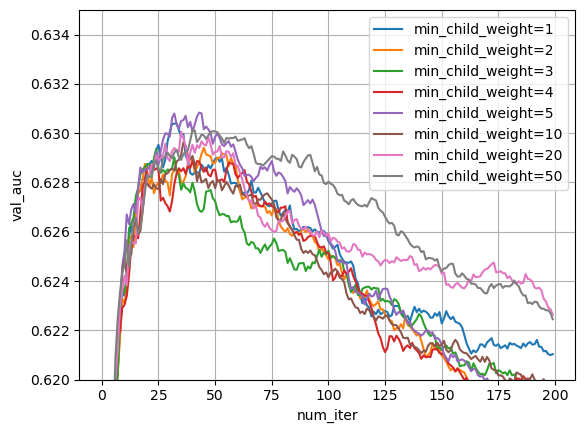

In [43]:
for key, df_scores in scores_min_child_weight.items():
    sns.lineplot(data=df_scores, x="num_iter", y="val_auc", label=key)

plt.grid()
plt.ylim(0.620,0.635)
plt.show()

In [38]:
scores_min_child_weight['min_child_weight=5'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
43,43,0.663929,0.630835
44,44,0.664316,0.630802


In [39]:
scores_min_child_weight['min_child_weight=1'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
33,33,0.661807,0.630397
32,32,0.661167,0.630383


In [40]:
scores_min_child_weight['min_child_weight=50'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
40,40,0.645890,0.630125
41,41,0.645959,0.630113


In [41]:
scores_min_child_weight['min_child_weight=20'].sort_values(by="val_auc", ascending=False).head(2)

,num_iter,train_auc,val_auc
35,35,0.651133,0.630064
47,47,0.656971,0.629841


**Conclusion**

Our best `min_child_weight` is 5 after num_iter = 43

### Evaluating the model with our chosen parameters

- `num_boost_round` = 43
- `eta` = 0.3
- `max_depth` = 4
- `min_child_weight` = 5


In [44]:
num_boost_round_final = 43
eta_final = 0.3
max_depth_final = 4
min_child_weight_final=5

xgb_final_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': eta_final, # default
    'max_depth': max_depth_final, 
    'min_child_weight': min_child_weight_final, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_final_params, dtrain, num_boost_round=num_boost_round_final)

y_pred = model.predict(dval)

roc_auc_score_tuning = roc_auc_score(y_val, y_pred)
roc_auc_score_tuning

np.float64(0.630676789526516)

In [47]:
roc_auc_score_base

np.float64(0.622532338315994)

**Observations**

Tuning the model has improve it by just under a percentage point from the base model
 

## Final model

I will use the full training set to train a model with the parameters found in the model tuning evaluation above.

In [62]:
# Prepare datasets: `is_severe` still exists in df_full_train so we need to remove it and extract the y_full_train
df_collision = pd.read_csv("../1_eda/data/collisions_final.csv")
df_full_train, df_test = train_test_split(df_collision, test_size=0.2, random_state=11)

df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_test = df_test["is_severe"].values
y_full_train = df_full_train["is_severe"].values

del df_full_train["is_severe"]
del df_test["is_severe"]

# Create dv and X_full_train and X_test datasets
dicts_full_train = df_full_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False).fit(dicts_full_train)
X_full_train = dv.transform(dicts_full_train)
# additional transforming for XGBoost
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)
# additional transforming for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

num_boost_round_final = 43
eta_final = 0.3
max_depth_final = 4
min_child_weight_final=5

xgb_final_params = {
    'booster': 'gbtree', # default
    'verbosity': 1, # default
    'nthread': 6, # how many cores/ how much parallelization, depends on your system

    'eta': eta_final, # default
    'max_depth': max_depth_final, 
    'min_child_weight': min_child_weight_final, # default

    'objective' :'binary:logistic', 
    'seed': 1, # random number seed to make the results reproducible
    'eval_metric': 'auc'
}

model = xgb.train(xgb_final_params, dfulltrain, num_boost_round=num_boost_round_final)

y_pred_test = model.predict(dtest)

roc_auc_score_final = roc_auc_score(y_test, y_pred_test)
roc_auc_score_final

np.float64(0.6288534117462088)

In [63]:
np.round(roc_auc_score_tuning,3) - np.round(roc_auc_score_final,3)

np.float64(0.0020000000000000018)

### Final model evaluation

Our final model has a slightly lower score (0.629 vs 0.631) than the model we built with the training set alone: the difference is a little greater than 0.002. This is a fraction of a percent so we can say that our model didn't overfit and generalised quite well to unseen data.

That being said, the `roc_auc_score` for this model is quite low. It is better than our logistic regression model and our RandomForest model so we will use this going forward.